In [1]:
!pip install xgboost optuna scikit-learn pandas numpy matplotlib seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 13.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
import warnings
import gc
from pandas.api.types import is_numeric_dtype
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
# Cấu hình
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [17]:
# Kiểm tra GPU
try:
    import torch
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        DEVICE = 'cuda'
        TREE_METHOD = 'hist'
    else:
        DEVICE = 'cpu'
        TREE_METHOD = 'hist'
except:
    DEVICE = 'cpu'
    TREE_METHOD = 'hist'

GPU: Tesla T4


# HÀM TỐI ƯU BỘ NHỚ

In [4]:
def reduce_mem_usage(df):
    """Giảm bộ nhớ bằng cách ép kiểu dữ liệu (Chỉ áp dụng cho số)"""
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        # Chỉ xử lý nếu là kiểu số (bỏ qua datetime, object)
        if is_numeric_dtype(df[col]):
            c_min = df[col].min()
            c_max = df[col].max()

            # Xử lý số nguyên
            if pd.api.types.is_integer_dtype(df[col]):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            # Xử lý số thực
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32) # Dùng float32 cho an toàn
                else:
                    df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Giảm RAM: {start_mem:.2f}MB -> {end_mem:.2f}MB')
    return df


#DATA PIPELINE (CHUNK PROCESSING CHO 1600+ TÒA NHÀ)

In [5]:
def load_and_process_global_data_chunked(url, chunk_size=100, max_buildings=None):
    """
    Xử lý từng nhóm tòa nhà để tránh tràn RAM
    chunk_size: Số lượng tòa nhà xử lý mỗi lần (mặc định 100)
    max_buildings: Tổng số tòa nhà muốn lấy (None = Lấy hết 1600+)
    """
    # Đọc index trước để đỡ tốn RAM
    df_raw = pd.read_csv(url, index_col='timestamp', parse_dates=True)

    # Lấy danh sách tòa nhà tốt (có dữ liệu > 10)
    valid_cols = [c for c in df_raw.columns if df_raw[c].mean() > 10]

    # Giới hạn số lượng nếu cần test
    if max_buildings:
        valid_cols = valid_cols[:max_buildings]
        print(f"Chế độ giới hạn: Chỉ lấy {len(valid_cols)} tòa nhà đầu tiên.")
    else:
        print(f"Chế độ Full: Sẽ xử lý toàn bộ {len(valid_cols)} tòa nhà.")

    # List chứa các DataFrame con đã melt
    processed_chunks = []

    # Chia nhỏ danh sách tòa nhà thành các chunk (0-100, 100-200...)
    total_cols = len(valid_cols)
    for i in range(0, total_cols, chunk_size):
        cols_chunk = valid_cols[i : i + chunk_size]
        print(f"Đang xử lý nhóm {i} đến {min(i+chunk_size, total_cols)}...")

        # 1. Lấy dữ liệu của chunk hiện tại
        df_chunk = df_raw[cols_chunk].copy()

        # 2. Fill NA & Interpolate
        df_chunk = df_chunk.interpolate(method='linear', limit_direction='both').fillna(0)

        # 3. Reset index để melt
        df_chunk = df_chunk.reset_index()

        # 4. Melt (Chuyển Wide sang Long)
        df_melted = pd.melt(df_chunk, id_vars=['timestamp'], var_name='building_name', value_name='load')

        # 5. Tối ưu bộ nhớ ngay lập tức
        df_melted = reduce_mem_usage(df_melted)

        processed_chunks.append(df_melted)

        # Dọn dẹp RAM
        del df_chunk, df_melted
        gc.collect()

    df_final = pd.concat(processed_chunks, axis=0, ignore_index=True)

    del df_raw, processed_chunks
    gc.collect()

    # Label Encoding & Log Transform
    le = LabelEncoder()
    df_final['building_id'] = le.fit_transform(df_final['building_name'])
    df_final['log_load'] = np.log1p(df_final['load']) # Log1p để chuẩn hóa scale

    # Bỏ cột tên string để tiết kiệm RAM
    df_final = df_final.drop(columns=['building_name'])

    return reduce_mem_usage(df_final), le

In [6]:
# CHẠY DATA PIPELINE
url = "https://github.com/buds-lab/building-data-genome-project-2/blob/master/data/meters/cleaned/electricity_cleaned.csv?raw=true"

df_all, label_encoder = load_and_process_global_data_chunked(url, chunk_size=50, max_buildings=200)

print(f"Tổng số dòng dữ liệu: {len(df_all):,}")

Chế độ giới hạn: Chỉ lấy 200 tòa nhà đầu tiên.
Đang xử lý nhóm 0 đến 50...
Giảm RAM: 20.08MB -> 16.73MB
Đang xử lý nhóm 50 đến 100...
Giảm RAM: 20.08MB -> 16.73MB
Đang xử lý nhóm 100 đến 150...
Giảm RAM: 20.08MB -> 16.73MB
Đang xử lý nhóm 150 đến 200...
Giảm RAM: 20.08MB -> 16.73MB
Giảm RAM: 80.31MB -> 60.23MB
Tổng số dòng dữ liệu: 3,508,800


# FEATURE ENGINEERING (GLOBAL & MEMORY EFFICIENT)

In [7]:
def create_global_features(df):
    # Sắp xếp để tính lag đúng
    df = df.sort_values(['building_id', 'timestamp'])

    # Thời gian
    df['hour'] = df.timestamp.dt.hour.astype(np.int8)
    df['dayofweek'] = df.timestamp.dt.dayofweek.astype(np.int8)
    df['month'] = df.timestamp.dt.month.astype(np.int8)

    # Cyclical
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24).astype(np.float32)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24).astype(np.float32)

    # Lag Features (Tính trên log_load)
    # Dùng groupby nhưng gán trực tiếp mảng numpy để nhanh hơn
    df['lag_1'] = df.groupby('building_id')['log_load'].shift(1).astype(np.float32)
    df['lag_24'] = df.groupby('building_id')['log_load'].shift(24).astype(np.float32)

    # Velocity (Đạo hàm bậc 1)
    df['diff_1'] = df.groupby('building_id')['log_load'].diff(1).astype(np.float32)

    # Xóa NaN sinh ra do lag
    df = df.dropna()
    return reduce_mem_usage(df)

In [8]:
df_features = create_global_features(df_all)

Giảm RAM: 163.74MB -> 163.74MB


In [9]:
# Xóa biến không dùng
del df_all
gc.collect()

41

#CHIA TRAIN/TEST

In [10]:
# Chia theo thời gian (20% cuối làm test)
split_date = df_features['timestamp'].quantile(0.8)

In [11]:
train_df = df_features[df_features['timestamp'] < split_date]
test_df = df_features[df_features['timestamp'] >= split_date]

In [12]:
# Features list
drop_cols = ['timestamp', 'load', 'log_load']
features = [c for c in df_features.columns if c not in drop_cols]
target = 'log_load'

In [13]:
print(f"Features: {features}")
X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

Features: ['building_id', 'hour', 'dayofweek', 'month', 'hour_sin', 'hour_cos', 'lag_1', 'lag_24', 'diff_1']


In [14]:
del df_features, train_df
gc.collect()

0

#OPTUNA TUNING

In [18]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 5),
        'tree_method': TREE_METHOD,
        'device': DEVICE,
        'objective': 'reg:squarederror',
        'early_stopping_rounds': 50
    }

    # Lấy mẫu nhỏ 10% để tune cho nhanh
    sample_idx = np.random.choice(len(X_train), int(len(X_train)*0.1), replace=False)
    X_sample = X_train.iloc[sample_idx]
    y_sample = y_train.iloc[sample_idx]

    # Chia train/val từ mẫu nhỏ
    val_size = int(len(X_sample) * 0.2)
    X_tr_s = X_sample.iloc[:-val_size]
    y_tr_s = y_sample.iloc[:-val_size]
    X_val_s = X_sample.iloc[-val_size:]
    y_val_s = y_sample.iloc[-val_size:]

    model = xgb.XGBRegressor(**param)
    model.fit(X_tr_s, y_tr_s, eval_set=[(X_val_s, y_val_s)], verbose=False)

    preds = model.predict(X_val_s)

    rmse = np.sqrt(mean_squared_error(y_val_s, preds))
    return rmse

In [19]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=3)

In [20]:
best_params = study.best_params
best_params.update({
    'tree_method': TREE_METHOD,
    'device': DEVICE,
    'objective': 'reg:squarederror',
    'early_stopping_rounds': 50
})
print(f"Tham số tốt nhất: {best_params}")

Tham số tốt nhất: {'n_estimators': 581, 'max_depth': 8, 'learning_rate': 0.11542167727929356, 'subsample': 0.8224961626378026, 'colsample_bytree': 0.8137416895158613, 'reg_alpha': 2.1975807394758515, 'reg_lambda': 1.0990819308866595, 'tree_method': 'hist', 'device': 'cuda', 'objective': 'reg:squarederror', 'early_stopping_rounds': 50}


#FINAL MODEL & EVALUATION

In [21]:
final_model = xgb.XGBRegressor(**best_params)

In [22]:
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

[0]	validation_0-rmse:1.05666	validation_1-rmse:0.99435
[100]	validation_0-rmse:0.02976	validation_1-rmse:0.02806
[200]	validation_0-rmse:0.02654	validation_1-rmse:0.02684
[300]	validation_0-rmse:0.02459	validation_1-rmse:0.02639
[400]	validation_0-rmse:0.02328	validation_1-rmse:0.02622
[500]	validation_0-rmse:0.02229	validation_1-rmse:0.02618
[506]	validation_0-rmse:0.02223	validation_1-rmse:0.02618


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8137416895158613, device='cuda',
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.11542167727929356,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=581, n_jobs=None,
             num_parallel_tree=None, ...)

In [23]:
# Dự báo
preds_log = final_model.predict(X_test)
preds_real = np.expm1(preds_log) # Inverse Log
y_test_real = np.expm1(y_test)

In [24]:
# Đánh giá
rmse = np.sqrt(mean_squared_error(y_test_real, preds_real))
mae = mean_absolute_error(y_test_real, preds_real)
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

RMSE: 14.8734
MAE:  1.9436


# DEMO PHÁT HIỆN BẤT THƯỜNG

In [25]:
# Chọn ngẫu nhiên 1 tòa nhà trong tập test để vẽ
sample_bid = np.random.choice(test_df['building_id'].unique())
mask = test_df['building_id'] == sample_bid

In [26]:
y_sub_real = y_test_real[mask]
pred_sub = preds_real[mask]

In [27]:
# Tính IQR Threshold
residuals = np.abs(y_sub_real - pred_sub)
roll_median = pd.Series(residuals).rolling(168, min_periods=1).median()
roll_iqr = pd.Series(residuals).rolling(168, min_periods=1).quantile(0.75) - \
           pd.Series(residuals).rolling(168, min_periods=1).quantile(0.25)
threshold = roll_median + (2.0 * roll_iqr) # K=2.0

In [28]:
anomalies = residuals > threshold

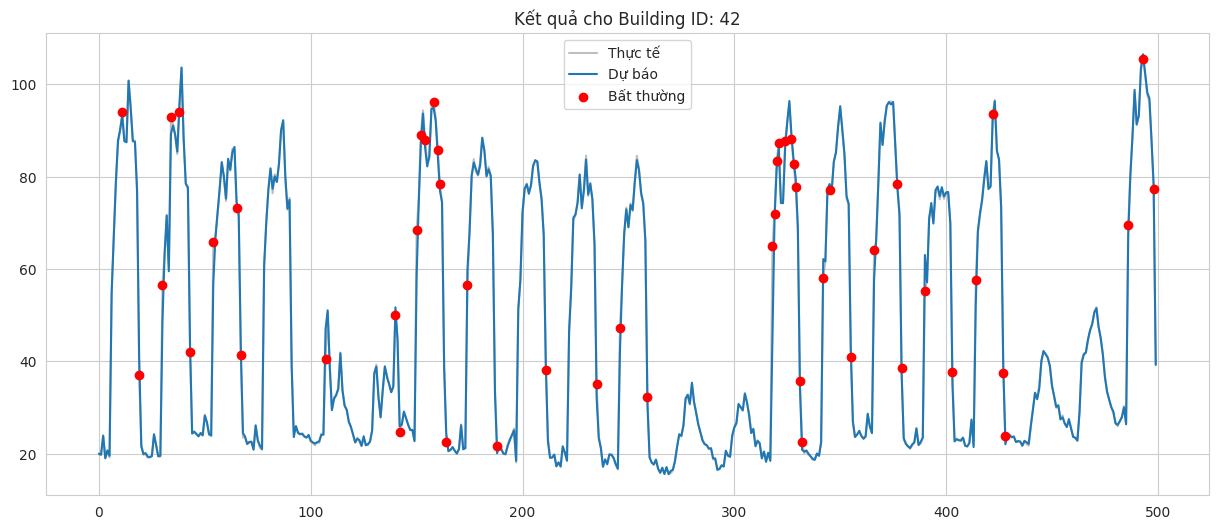

In [29]:
plt.figure(figsize=(15, 6))
plt.plot(y_sub_real.values[:500], label='Thực tế', color='gray', alpha=0.5)
plt.plot(pred_sub[:500], label='Dự báo', color='#1f77b4')
plt.scatter(np.where(anomalies[:500])[0], y_sub_real.values[:500][anomalies[:500]],
            color='red', label='Bất thường', zorder=10)
plt.title(f"Kết quả cho Building ID: {sample_bid}")
plt.legend()
plt.show()

#ĐÁNH GIÁ PHÁT HIỆN BẤT THƯỜNG TOÀN CỤC (GLOBAL EVALUATION)

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# Chuẩn bị DataFrame đánh giá
# Lấy lại Building ID từ X_test để group
eval_df = X_test[['building_id']].copy()
eval_df['timestamp'] = test_df['timestamp'] # Lấy lại thời gian
eval_df['load_real'] = y_test_real          # Tải thực tế (Clean)
eval_df['load_pred'] = preds_real           # Dự báo của mô hình

In [32]:
# Tiêm lỗi nhân tạo (Global Injection)
# Tăng 50% tải tại 5% số điểm dữ liệu ngẫu nhiên trên toàn bộ tập test
np.random.seed(42)
injection_mask = np.random.choice([True, False], size=len(eval_df), p=[0.05, 0.95])

In [33]:
eval_df['load_injected'] = np.where(injection_mask,
                                    eval_df['load_real'] * 1.5, # Lỗi: Tăng 1.5 lần
                                    eval_df['load_real'])       # Bình thường
eval_df['label_true'] = injection_mask.astype(int) # Nhãn thực tế (1=Lỗi, 0=Sạch)

print(f"Đã tiêm {injection_mask.sum():,} điểm bất thường vào dữ liệu.")

Đã tiêm 34,701 điểm bất thường vào dữ liệu.


# Tính ngưỡng IQR riêng cho TỪNG TÒA NHÀ (Batch Contextual Threshold)

In [34]:
# Tính sai số dự báo (trên dữ liệu sạch - Baseline)
eval_df['residual_baseline'] = np.abs(eval_df['load_real'] - eval_df['load_pred'])

In [35]:
# GroupBy theo Building_ID để tính IQR cho riêng từng tòa nhà
gb = eval_df.groupby('building_id')['residual_baseline']
eval_df['median_res'] = gb.transform('median')
eval_df['q1_res'] = gb.transform(lambda x: x.quantile(0.25))
eval_df['q3_res'] = gb.transform(lambda x: x.quantile(0.75))
eval_df['iqr_res'] = eval_df['q3_res'] - eval_df['q1_res']

In [36]:
# Thiết lập ngưỡng động
# K_SIGMA = 3.0: Ngưỡng để giảm báo động giả
K_SIGMA = 3.0
eval_df['dynamic_threshold'] = eval_df['median_res'] + (K_SIGMA * eval_df['iqr_res'])

In [37]:
# Clip ngưỡng tối thiểu (10% tải trung bình của tòa nhà đó)
eval_df['min_threshold'] = eval_df.groupby('building_id')['load_real'].transform('mean') * 0.1
eval_df['final_threshold'] = np.maximum(eval_df['dynamic_threshold'], eval_df['min_threshold'])

# Phát hiện bất thường trên dữ liệu ĐÃ TIÊM LỖI

In [38]:
# Tính sai số thực tế (giữa dữ liệu lỗi và dự báo)
eval_df['residual_injected'] = np.abs(eval_df['load_injected'] - eval_df['load_pred'])

In [39]:
# So sánh với ngưỡng đã học
eval_df['label_pred'] = (eval_df['residual_injected'] > eval_df['final_threshold']).astype(int)

In [40]:
# Tính chỉ số đánh giá (Metrics)
precision = precision_score(eval_df['label_true'], eval_df['label_pred'])
recall = recall_score(eval_df['label_true'], eval_df['label_pred'])
f1 = f1_score(eval_df['label_true'], eval_df['label_pred'])

In [41]:
print(f"Tổng số mẫu test: {len(eval_df):,}")
print(f"Số lượng Building: {eval_df['building_id'].nunique()}")

Tổng số mẫu test: 700,800
Số lượng Building: 200


In [42]:
print(f"Precision: {precision:.4f}  (Độ tin cậy của cảnh báo)")
print(f"Recall:    {recall:.4f}  (Khả năng phát hiện sự cố)")
print(f"F1-Score:  {f1:.4f}  (Cân bằng)")

Precision: 0.9191  (Độ tin cậy của cảnh báo)
Recall:    0.9922  (Khả năng phát hiện sự cố)
F1-Score:  0.9542  (Cân bằng)


#TRỰC QUAN HÓA CHI TIẾT 1 TÒA NHÀ BẤT KỲ

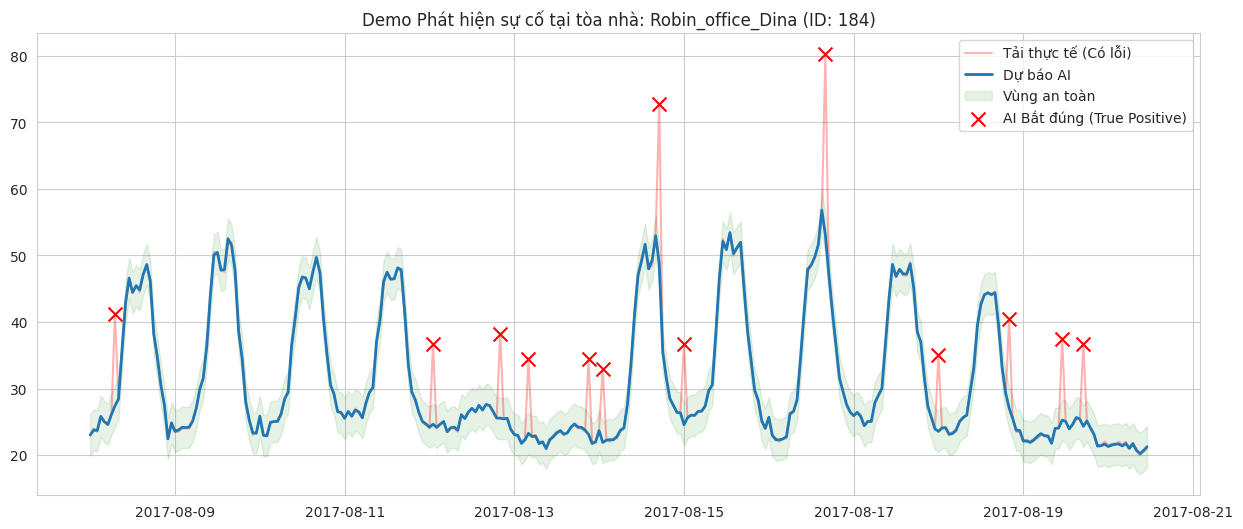

In [43]:
tp_buildings = eval_df[(eval_df['label_true']==1) & (eval_df['label_pred']==1)]['building_id'].unique()

if len(tp_buildings) > 0:
    demo_id = np.random.choice(tp_buildings)
    df_plot = eval_df[eval_df['building_id'] == demo_id].iloc[:300] # Lấy 300 giờ đầu

    plt.figure(figsize=(15, 6))

    # Vẽ tải
    plt.plot(df_plot['timestamp'], df_plot['load_injected'], color='red', alpha=0.3, label='Tải thực tế (Có lỗi)')
    plt.plot(df_plot['timestamp'], df_plot['load_pred'], color='#1f77b4', linewidth=2, label='Dự báo AI')

    # Vẽ vùng an toàn
    plt.fill_between(df_plot['timestamp'],
                     df_plot['load_pred'] - df_plot['final_threshold'],
                     df_plot['load_pred'] + df_plot['final_threshold'],
                     color='green', alpha=0.1, label='Vùng an toàn')

    # Vẽ điểm bất thường bắt được
    tp_points = df_plot[(df_plot['label_true']==1) & (df_plot['label_pred']==1)]
    plt.scatter(tp_points['timestamp'], tp_points['load_injected'],
                color='red', s=100, marker='x', label='AI Bắt đúng (True Positive)', zorder=10)

    try:
        # Nếu label_encoder còn tồn tại
        b_name = label_encoder.inverse_transform([demo_id])[0]
    except:
        b_name = str(demo_id)

    plt.title(f"Demo Phát hiện sự cố tại tòa nhà: {b_name} (ID: {demo_id})")
    plt.legend()
    plt.show()
else:
    print("Không tìm thấy tòa nhà nào có phát hiện đúng để vẽ.")

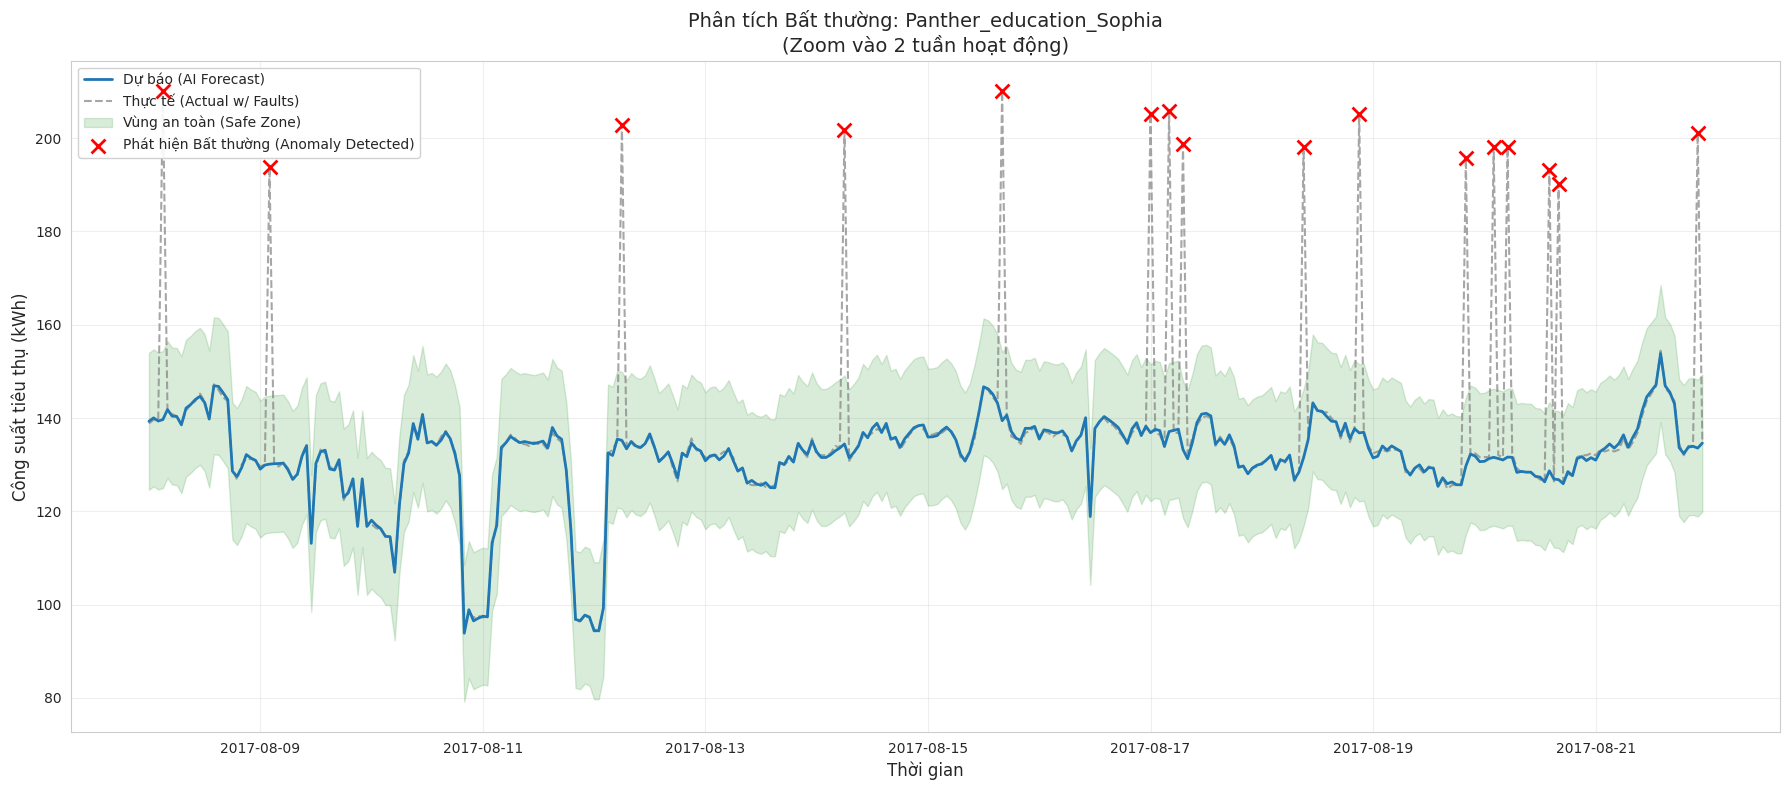

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Chọn ngẫu nhiên 1 tòa nhà có phát hiện đúng lỗi (True Positive)
tp_buildings = eval_df[(eval_df['label_true'] == 1) & (eval_df['label_pred'] == 1)]['building_id'].unique()

if len(tp_buildings) > 0:
    demo_id = np.random.choice(tp_buildings)

    # Lấy dữ liệu của tòa nhà đó
    df_plot = eval_df[eval_df['building_id'] == demo_id].copy()

    # Chỉ lấy khoảng 2 tuần (336 giờ) có chứa lỗi để zoom vào cho rõ
    # Tìm điểm lỗi đầu tiên
    first_anomaly_idx = df_plot[df_plot['label_true'] == 1].index[0]
    start_idx = max(0, df_plot.index.get_loc(first_anomaly_idx) - 50)
    end_idx = min(len(df_plot), start_idx + 336)

    df_zoom = df_plot.iloc[start_idx:end_idx]

    # --- VẼ ---
    plt.figure(figsize=(18, 8))

    # 1. Đường Dự báo (AI Model)
    plt.plot(df_zoom['timestamp'], df_zoom['load_pred'],
             color='#1f77b4', linewidth=2, label='Dự báo (AI Forecast)', zorder=5)

    # 2. Đường Thực tế (Có lỗi tiêm vào)
    plt.plot(df_zoom['timestamp'], df_zoom['load_injected'],
             color='gray', linestyle='--', alpha=0.7, label='Thực tế (Actual w/ Faults)', zorder=4)

    # 3. Vùng Ngưỡng động (Dynamic Threshold Band)
    # Đây là vùng "Chấp nhận được". Ra khỏi vùng này là Bất thường.
    plt.fill_between(df_zoom['timestamp'],
                     df_zoom['load_pred'] - df_zoom['final_threshold'],
                     df_zoom['load_pred'] + df_zoom['final_threshold'],
                     color='green', alpha=0.15, label='Vùng an toàn (Safe Zone)')

    # 4. Đánh dấu điểm Bất thường AI phát hiện (True Positive)
    tp_mask = (df_zoom['label_true'] == 1) & (df_zoom['label_pred'] == 1)
    plt.scatter(df_zoom[tp_mask]['timestamp'], df_zoom[tp_mask]['load_injected'],
                color='red', s=100, marker='x', linewidth=2,
                label='Phát hiện Bất thường (Anomaly Detected)', zorder=10)

    # Lấy tên tòa nhà (nếu có encoder)
    try:
        b_name = label_encoder.inverse_transform([demo_id])[0]
    except:
        b_name = f"Building_ID_{demo_id}"

    plt.title(f"Phân tích Bất thường: {b_name}\n(Zoom vào 2 tuần hoạt động)", fontsize=14)
    plt.ylabel("Công suất tiêu thụ (kWh)", fontsize=12)
    plt.xlabel("Thời gian", fontsize=12)
    plt.legend(loc='upper left', frameon=True, fancybox=True, framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print("Không tìm thấy tòa nhà nào có True Positive để vẽ.")

In [ ]:
import pickle
from google.colab import files

# Lưu mô hình XGBoost
model_filename = "xgboost_global_model_v1-GPU.json"
final_model.save_model(model_filename)

# Lưu Label Encoder (để map ID tòa nhà)
encoder_filename = "label_encoder_v1-GPU.pkl"
with open(encoder_filename, 'wb') as f:
    pickle.dump(label_encoder, f)

# Kích hoạt tải xuống trình duyệt
try:
    files.download(model_filename)
    files.download(encoder_filename)
except Exception as e:
    print(f"Lỗi khi tải xuống tự động: {e}")